In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import  glob
import seaborn as sns

tocategory = lambda col: pd.Categorical(col)
underscoretospace = lambda x: x.replace("_", " ") if type(x) is str else x
def q5(x): return x.quantile(.05)
def q95(x): return x.quantile(.95)

In [2]:
filenames = glob.glob("data/lsb.*.r*")
params = ["Algorithm", "Max threads", "Graph nodes"];

In [3]:
def get_df(filename):
    return (pd
      .read_csv(filename, sep=" ", comment="#", skipinitialspace=True, index_col="id")
      .applymap(underscoretospace)
      .dropna("columns", "all")
    )
df = pd.concat(get_df(filename) for filename in filenames)
df[["Algorithm", "Graph_name"]] = df[["Algorithm", "Graph_name"]].apply(tocategory)
df.columns = df.columns.map(underscoretospace)

In [4]:
df.head(5)

,Algorithm,Graph nodes,Graph name,Max threads,run,time,overhead
id,,,,,,,
0,parallel sollin AL,264346,USA-road-d.,1,0,4.211594e+06,0
1,parallel sollin AL,264346,USA-road-d.,1,1,4.544443e+06,0
2,parallel sollin AL,264346,USA-road-d.,1,2,4.426084e+06,0
3,parallel sollin AL,264346,USA-road-d.,1,3,4.527441e+06,0
4,parallel sollin AL,264346,USA-road-d.,1,4,4.472536e+06,0


In [5]:
df.tail(5)

,Algorithm,Graph nodes,Graph name,Max threads,run,time,overhead
id,,,,,,,
295,parallel sollin EL,264346,USA-road-d.,32,45,5.380670e+06,0
296,parallel sollin EL,264346,USA-road-d.,32,46,5.268356e+06,0
297,parallel sollin EL,264346,USA-road-d.,32,47,5.200396e+06,4
298,parallel sollin EL,264346,USA-road-d.,32,48,5.172083e+06,0
299,parallel sollin EL,264346,USA-road-d.,32,49,5.383098e+06,4


In [6]:
timequantiles = df.groupby(params).agg([q5, q95])["time"]
df_timequantiles =  timequantiles.loc[map(tuple, df[params].values)]

In [7]:
summary = (df[params + ["time"]]
    [(df.time >= df_timequantiles["q5"].values) & (df.time <= df_timequantiles["q95"].values)]
    .groupby(params).agg(["median", "mean", "min", "max", "std"])
)

In [8]:
summary

time                \
                                                  median          mean   
Algorithm          Max threads Graph nodes                               
Filter Kruskal     1           100          3.419668e+02  5.040903e+02   
                               1000         3.412258e+03  3.518408e+03   
                               10000        4.549411e+04  4.661793e+04   
                               264346       1.663206e+06  1.639267e+06   
                   2           100          2.886252e+02  2.972459e+02   
                               1000         3.406552e+03  3.276106e+03   
                               10000        4.510894e+04  4.525327e+04   
                               264346       1.626643e+06  1.651143e+06   
                   4           100          3.144744e+02  3.164913e+02   
                               1000         3.272505e+03  3.360690e+03   
                               10000        4.556905e+04  4.735752e+04   
                               264346       1.583594e+06  1.609746e+06   
                   8           100          2.990968e+02  3.147530e+02   
                               1000         3.310781e+03  3.396987e+03   
                               10000        4.392397e+04  4.520114e+04   
                               264346       1.596367e+06  1.631712e+06   
                   16          100          3.045653e+02  3.135458e+02   
                               1000         3.468475e+03  3.489821e+03   
                               10000        4.572624e+04  4.683015e+04   
                               264346       1.569801e+06  1.601831e+06   
                   32          100          3.068948e+02  3.168957e+02   
                               1000         3.148087e+03  3.277075e+03   
                               10000        4.844859e+04  4.744001e+04   
                               264346       1.560421e+06  1.587416e+06   
Sequential Kruskal 1           100          2.678096e+02  4.298633e+02   
                               1000         3.406880e+03  3.411459e+03   
                               10000        5.005919e+04  5.045609e+04   
                               264346       7.448984e+05  7.535983e+05   
Sollin             1           100          3.123667e+03  3.136284e+03   
                               1000         5.314725e+04  5.323163e+04   
...                                                  ...           ...   
parallel sollin AL 16          10000        6.164952e+05  6.160852e+05   
                               264346       4.125206e+06  4.149225e+06   
                   32          100          7.485527e+03  7.662213e+03   
                               1000         7.090206e+04  7.119603e+04   
                               10000        8.023416e+05  8.108756e+05   
                               264346       5.041760e+06  5.056883e+06   
parallel sollin EL 1           100          7.113323e+03  7.103758e+03   
                               1000         5.055997e+04  5.077688e+04   
                               10000        4.560138e+05  4.566395e+05   
                               264346       1.612282e+06  1.631938e+06   
                   2           100          8.192421e+03  8.057591e+03   
                               1000         6.591332e+04  6.594162e+04   
                               10000        5.018433e+05  5.405188e+05   
                               264346       2.022942e+06  1.954296e+06   
                   4           100          9.166394e+03  9.087560e+03   
                               1000         7.029223e+04  7.075803e+04   
                               10000        7.193108e+05  7.449009e+05   
                               264346       2.723737e+06  2.628529e+06   
                   8           100          9.859620e+03  9.880697e+03   
                               1000         8.937305e+04  8.963523e+04   
                               10000        8.564788e+05

In [9]:
g_idx = ["Graph nodes", "Graph name"]
graphs = df[g_idx].drop_duplicates().values

/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


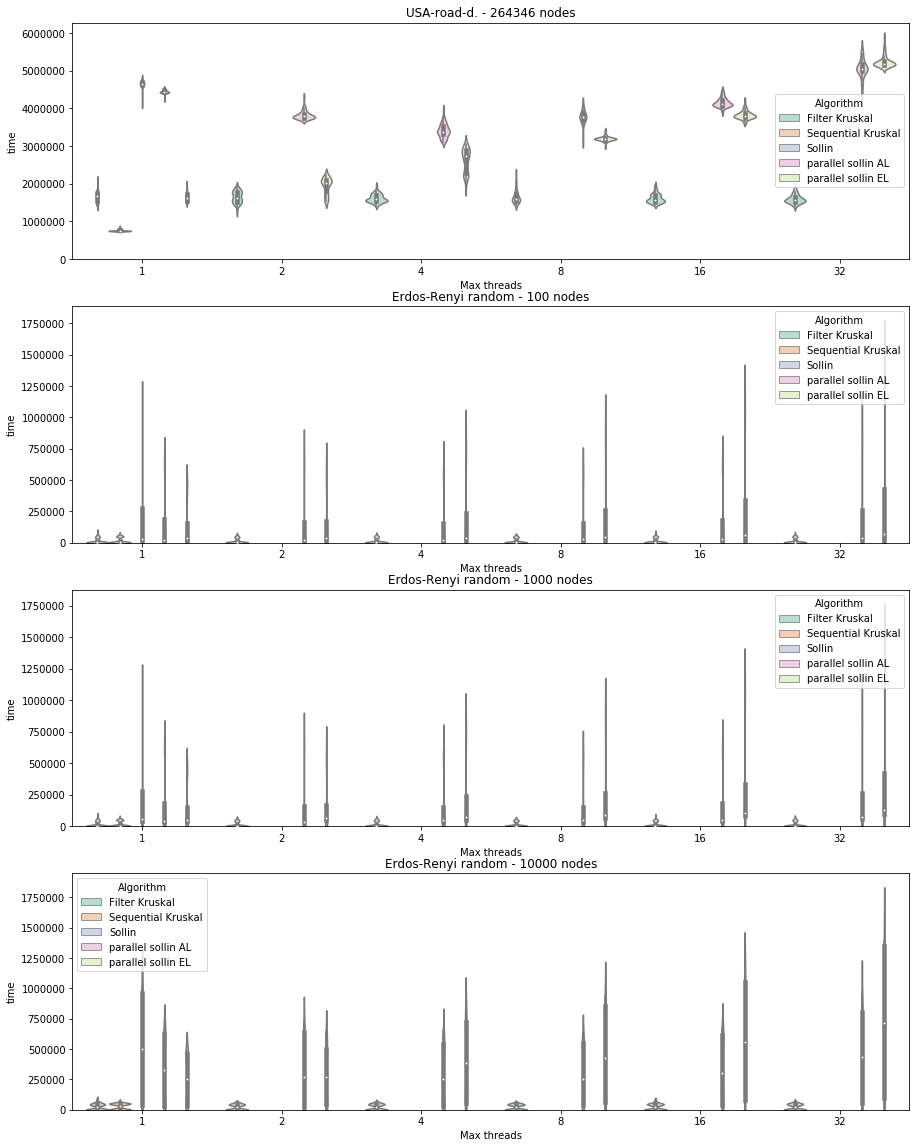

In [10]:
fig, ax = plt.subplots(nrows=len(graphs),figsize=(15,5*len(graphs)))
for i, e in enumerate(graphs):
    sns.violinplot(
        x="Max threads", y="time", hue="Algorithm", 
        data=df[df[g_idx].values == e], 
        palette="Pastel2", ax=ax[i]
    )
    ax[i].set_title(f"{e[1]} - {e[0]} nodes")
    ax[i].set_ylim(0,)

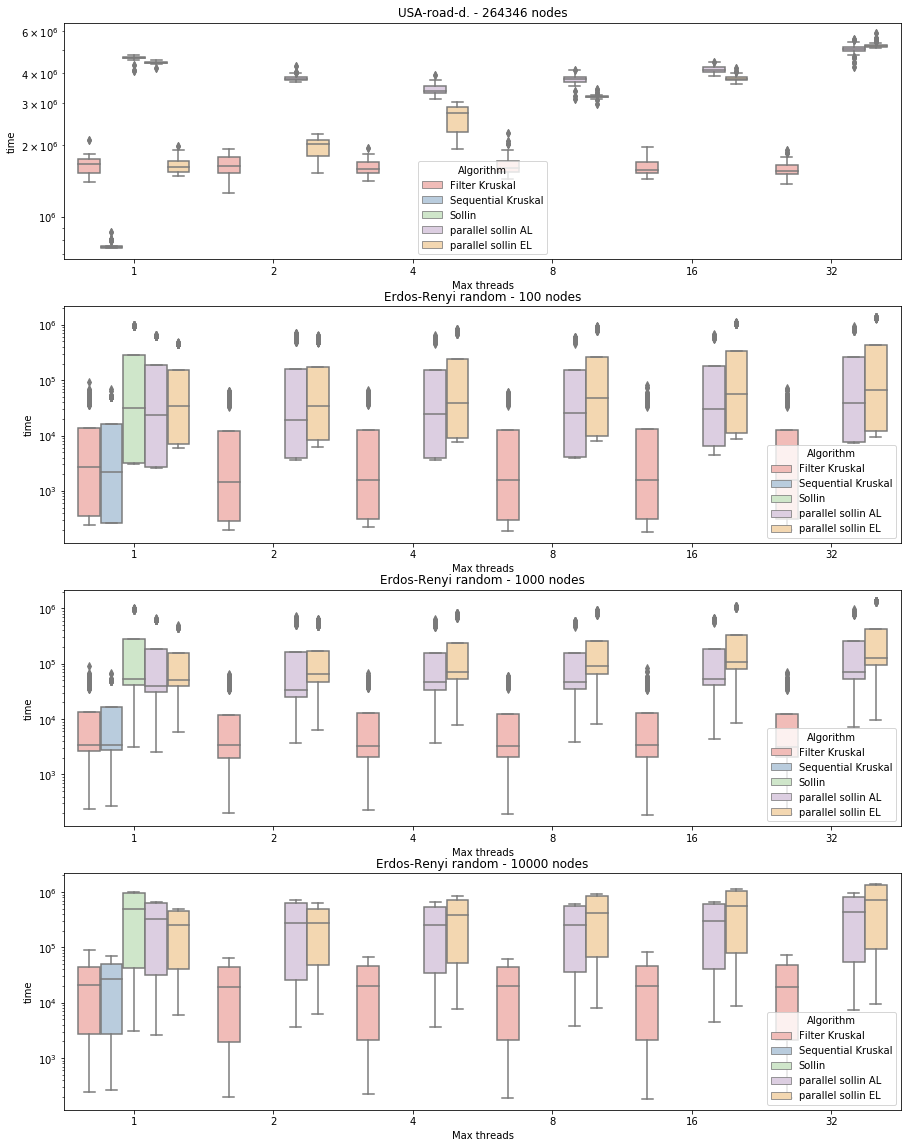

In [11]:
fig, ax = plt.subplots(nrows=len(graphs),figsize=(15,5*len(graphs)))
for i, e in enumerate(graphs):
    sns.boxplot(
        x="Max threads", y="time", hue="Algorithm", 
        data=df[df[g_idx].values == e], 
        palette="Pastel1", ax=ax[i]
    ).set(yscale="log")
    ax[i].set_title(f"{e[1]} - {e[0]} nodes")